In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import numpy as np

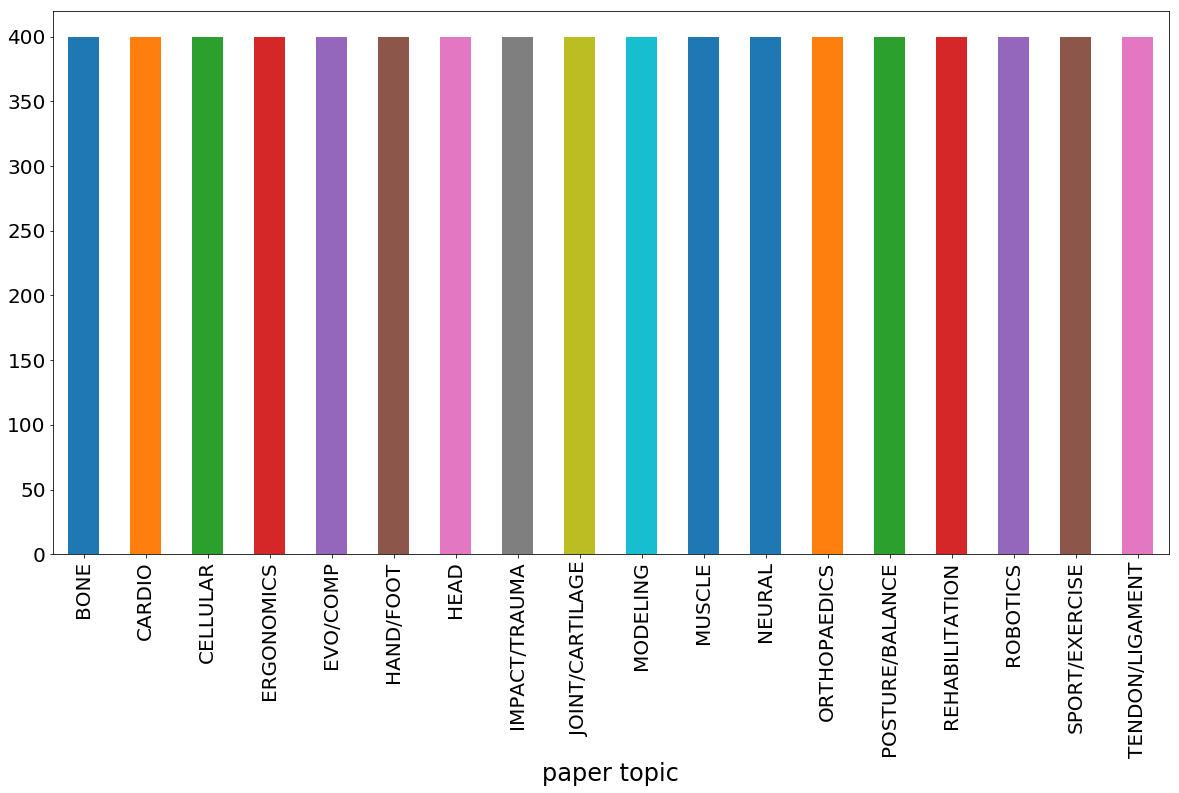

In [3]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
%matplotlib inline
import pandas as pd
from io import StringIO
#mac
# df = pd.read_csv("/Users/ryanalcantara/Professional Drive/Subreddit/code_repo/literature_update/RYANDATA_trim.csv")
#pc
df = pd.read_csv(r'C:\Users\ryans\Pro Drive\Subreddit\code_repo\literature_update\RYANDATA_trim.csv')

col = ['topic','title']
df = df[col]
df = df[pd.notnull(df['title'])]

df.columns = ['topic','title']

df['topic_id'] = df['topic'].factorize()[0]
topic_id_df = df[['topic',
                  'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id','topic']].values)
df.sample(5)

#histo of topics (ideally have >600 each)
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
fig = plt.figure(figsize= (20,10))
df.groupby('topic').title.count().plot.bar(ylim=0)
plt.xlabel("paper topic",fontsize = 24)
plt.show()

#need to consolidate Pick of the Week papers (or just exclude them)

In [ ]:

# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(sublinear_tf = True,
#                        min_df = 1,
#                        norm = 'l2',
#                        encoding = 'latin-1',
#                        ngram_range = (1,2),
#                        stop_words = 'english')

# features = tfidf.fit_transform(df.title).toarray()
# labels = df.topic_id
# print(features.shape) #(a,b) a num of titles is represented by b num of features

# from sklearn.feature_selection import chi2
# import numpy as np

# N = 2
# for topic, topic_id in sorted(topic_to_id.items()):
#     features_chi2 = chi2(features, labels == topic_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     #print("# '{}':".format(topic))
#     #print(". Most correlated unigrams:\n . {}".format('\n . '.join(unigrams[-N:])))
#     #print(". Most correlated bigrams:\n . {}".format('\n . '.join(bigrams[-N:])))
#     #print("")

In [ ]:
# #naive bayes classifier
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB

# X_train, X_test, y_train, y_test = train_test_split(df['title'],
#                                                     df['topic'],
#                                                     random_state = 0)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# clf = MultinomialNB().fit(X_train_tfidf,y_train)

# print(clf.predict(count_vect.transform([
#     "The simple chaotic model of passive dynamic walking. ",
# ]))) #
# #needs some help still...

# #df[df['title'] == "Journey into bone models: a review."]
# #not broken!



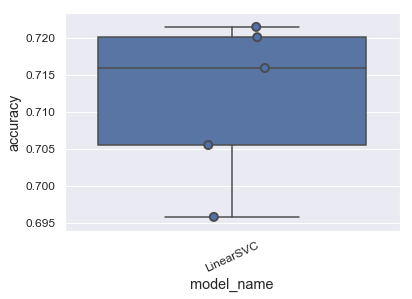

model_name
LinearSVC    0.711806
Name: accuracy, dtype: float64

In [22]:
#model selection!

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf = True,
                       min_df = 1,
                       norm = 'l2',
                       encoding = 'latin-1',
                       ngram_range = (1,2),
                       stop_words = 'english')
# https://scikit-learn.org/stable/modules/multiclass.html
features = tfidf.fit_transform(df.title).toarray()
labels = df.topic_id

models = [
    #RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0), #sucks
    LinearSVC(multi_class='ovr', random_state=0), #one vs rest (all)
#     SGDClassifier(max_iter=500, random_state=0, tol = 1e-3),
#     PassiveAggressiveClassifier(max_iter = 500, random_state = 0, tol = 1e-3)
    #MultinomialNB(),
    #LogisticRegression(random_state=0, solver = 'liblinear', multi_class = 'ovr'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.rc('xtick',labelsize = 12)
plt.rc('ytick',labelsize = 12)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.xticks( rotation='25')

plt.show()

cv_df.groupby('model_name').accuracy.mean()

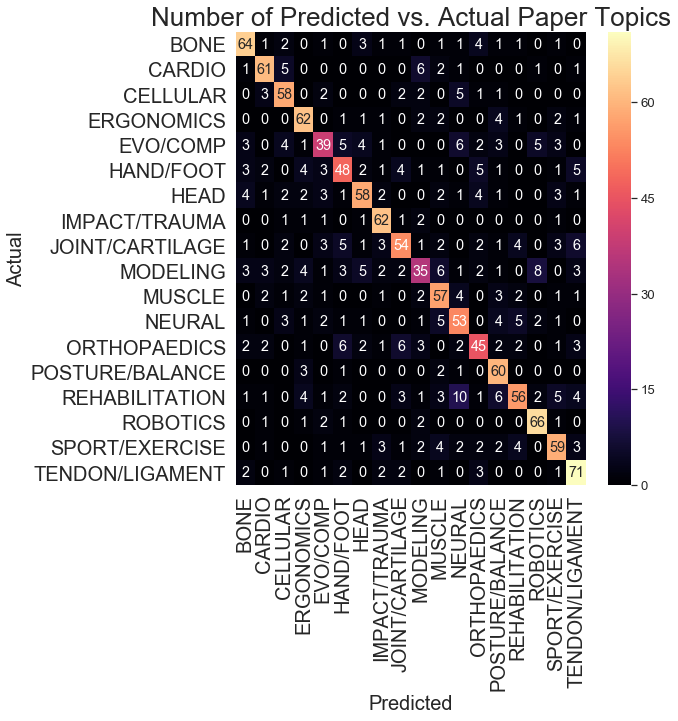

In [26]:
from sklearn.model_selection import train_test_split
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout(pad = 8)
sns.set(font_scale=1.2) #font size multiplier
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = 'magma',
            xticklabels=topic_id_df.topic.values, yticklabels=topic_id_df.topic.values)

plt.ylabel('Actual',fontsize = 20)
plt.xlabel('Predicted',fontsize = 20)
plt.title('Number of Predicted vs. Actual Paper Topics', fontsize = 26)
plt.yticks( rotation='horizontal')

plt.savefig('biomchL_predict_plot.png')
plt.show()


In [28]:
from IPython.display import display

for predicted in topic_id_df.topic_id:
    for actual in topic_id_df.topic_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_topic[actual], id_to_topic[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['topic', 'title']])
            print('')
            


'EVO/COMP' predicted as 'BONE' : 3 examples.


,topic,title
1917,EVO/COMP,Quantifying lateral femoral condyle elliptical...
1788,EVO/COMP,Nemaflex: a microfluidics-based technology for...
1783,EVO/COMP,Maintaining mobility after fracture: a biomech...



'HAND/FOOT' predicted as 'BONE' : 3 examples.


,topic,title
2103,HAND/FOOT,Deformable image registration and 3d strain ma...
2124,HAND/FOOT,Forces in the distal radius during a pushup or...
2325,HAND/FOOT,Bone shape difference between control and oste...



'HEAD' predicted as 'BONE' : 4 examples.


,topic,title
2658,HEAD,Contribution of biomechanical forces to inflam...
2518,HEAD,"Interactions of regenerative, inflammatory and..."
2714,HEAD,Bone microstrain values of 1-piece and 2-piece...
2615,HEAD,Mandibular corpus bone strains during masticat...



'MODELING' predicted as 'BONE' : 3 examples.


,topic,title
3656,MODELING,Large-scale finite element analysis of human c...
3740,MODELING,Material assignment in finite element modeling...
3750,MODELING,Mimetization of the elastic properties of canc...



'ORTHOPAEDICS' predicted as 'BONE' : 2 examples.


,topic,title
4839,ORTHOPAEDICS,Reconstruction of radial bone defects using th...
4838,ORTHOPAEDICS,Development of femoral head interior supportin...



'TENDON/LIGAMENT' predicted as 'BONE' : 2 examples.


,topic,title
6861,TENDON/LIGAMENT,The effects of extracorporeal shock waves on c...
6831,TENDON/LIGAMENT,Rotator cuff healing using demineralized cance...



'CELLULAR' predicted as 'CARDIO' : 3 examples.


,topic,title
874,CELLULAR,Real-time study of shape and thermal fluctuati...
1142,CELLULAR,Role of constitutive behavior and tumor-host m...
1066,CELLULAR,Structural and biomechanical characterizations...



'HAND/FOOT' predicted as 'CARDIO' : 2 examples.


,topic,title
2308,HAND/FOOT,Anatomic limitations of the transmetatarsal am...
2267,HAND/FOOT,Intraosseous and extraosseous arterial anatomy...



'MODELING' predicted as 'CARDIO' : 3 examples.


,topic,title
3994,MODELING,A re-engineered software interface and workflo...
3935,MODELING,Invited comment to the 'abdoman': an artificia...
3664,MODELING,Three-dimensional geometry of the human caroti...



'MUSCLE' predicted as 'CARDIO' : 2 examples.


,topic,title
4013,MUSCLE,Near-infrared spectroscopy using indocyanine g...
4309,MUSCLE,Effects of respiratory muscle work onrespirato...



'ORTHOPAEDICS' predicted as 'CARDIO' : 2 examples.


,topic,title
4832,ORTHOPAEDICS,Pathogenesis of the intravertebral vacuum of k...
5150,ORTHOPAEDICS,Examination of an in vitro methodology to eval...



'BONE' predicted as 'CELLULAR' : 2 examples.


,topic,title
311,BONE,Implications of schwann cells biomechanics and...
187,BONE,Cobalt and titanium nanoparticles influence on...



'CARDIO' predicted as 'CELLULAR' : 5 examples.


,topic,title
527,CARDIO,Multiscale modeling of intracranial aneurysms:...
719,CARDIO,Cigarette smoke alters the biomechanical prope...
517,CARDIO,Septic cardiomyopathy in rat lps-induced endot...
660,CARDIO,On the functional role of valve interstitial c...
489,CARDIO,Device-based in vitro techniques for mechanica...



'EVO/COMP' predicted as 'CELLULAR' : 4 examples.


,topic,title
1632,EVO/COMP,Uptake of tio2 nanoparticles into c
1921,EVO/COMP,In situ vocal fold properties and pitch predic...
1859,EVO/COMP,Mechanical properties of a &itdrosophila&it la...
1615,EVO/COMP,Collective structures anchor massive schools o...



'HEAD' predicted as 'CELLULAR' : 2 examples.


,topic,title
2793,HEAD,"The role of mitochondria, oxidative stress, an..."
2640,HEAD,Infiltration of chitin by protein coacervates ...



'JOINT/CARTILAGE' predicted as 'CELLULAR' : 2 examples.


,topic,title
3311,JOINT/CARTILAGE,Manually and automatically produced pellet cul...
3424,JOINT/CARTILAGE,Softening substrates promote chondrocytes phen...



'MODELING' predicted as 'CELLULAR' : 2 examples.


,topic,title
3956,MODELING,Micro-to-nano biomechanical modeling for assis...
3645,MODELING,Interaction between brush layers of bottle-bru...



'NEURAL' predicted as 'CELLULAR' : 3 examples.


,topic,title
4733,NEURAL,Role of olivocerebellar system in timing witho...
4770,NEURAL,Effects of the post-spinal cord injury microen...
4656,NEURAL,Updating of the spatial reference frame of hea...



'HAND/FOOT' predicted as 'ERGONOMICS' : 4 examples.


,topic,title
2234,HAND/FOOT,Unraveling mysteries of personal performance s...
2247,HAND/FOOT,Association between work-related biomechanical...
2048,HAND/FOOT,Wearable nail deformation sensing for behavior...
2095,HAND/FOOT,Evaluation of cast creep occurring during simu...



'HEAD' predicted as 'ERGONOMICS' : 2 examples.


,topic,title
2776,HEAD,Altering user movement behaviour in virtual en...
2652,HEAD,Analyzing center of rotation during opening an...



'MODELING' predicted as 'ERGONOMICS' : 4 examples.


,topic,title
3637,MODELING,Finite element simulation of the mechanical im...
3807,MODELING,Mathematical modelling of biomechanical intera...
3776,MODELING,"Comparison of trunk muscle forces, spinal load..."
3731,MODELING,Physical limits to biomechanical sensing in di...



'MUSCLE' predicted as 'ERGONOMICS' : 2 examples.


,topic,title
4391,MUSCLE,Subjective evaluation of physical and mental w...
4355,MUSCLE,The developing shoulder has a limited capacity...



'POSTURE/BALANCE' predicted as 'ERGONOMICS' : 3 examples.


,topic,title
5583,POSTURE/BALANCE,The influences of foot placement on lumbopelvi...
5463,POSTURE/BALANCE,Low cost self-made pressure distribution senso...
5524,POSTURE/BALANCE,Relevance of adding a triangular dynamic cushi...



'REHABILITATION' predicted as 'ERGONOMICS' : 4 examples.


,topic,title
5820,REHABILITATION,Efficiency of three treatment strategies on oc...
5939,REHABILITATION,Enhancing clinically-relevant shoulder functio...
5844,REHABILITATION,Incidence of certified need of care in the lon...
5779,REHABILITATION,Vision system-based design and assessment of a...



'CELLULAR' predicted as 'EVO/COMP' : 2 examples.


,topic,title
1086,CELLULAR,"The wingtips of the pterosaurs: anatomy, aeron..."
800,CELLULAR,The two domains of centrin have distinct basal...



'HAND/FOOT' predicted as 'EVO/COMP' : 3 examples.


,topic,title
2090,HAND/FOOT,Anatomic description of the ulna of the white-...
2041,HAND/FOOT,A repeatable geometric morphometric approach t...
2175,HAND/FOOT,"Re: Havulinna j, leppanen ov, jarvinen tln, go..."



'HEAD' predicted as 'EVO/COMP' : 3 examples.


,topic,title
2462,HEAD,Fast detector/first responder: interactions be...
2455,HEAD,Is topography guided crosslinking the next sta...
2551,HEAD,Biomechanical comparison of two ostectomy conf...



'JOINT/CARTILAGE' predicted as 'EVO/COMP' : 3 examples.


,topic,title
3367,JOINT/CARTILAGE,A comparative study of the effects of vein-joi...
3354,JOINT/CARTILAGE,Predictors of shoulder degeneration in the kwa...
3235,JOINT/CARTILAGE,Differential limb loading in miniature pigs (s...



'NEURAL' predicted as 'EVO/COMP' : 2 examples.


,topic,title
4598,NEURAL,Estimating sensorimotor mapping from stimuli t...
4473,NEURAL,Enhanced locomotor adaptation aftereffect in t...



'ROBOTICS' predicted as 'EVO/COMP' : 2 examples.


,topic,title
6169,ROBOTICS,"From ""ear"" to there: a review of biorobotic mo..."
6059,ROBOTICS,Functional redesign of mantis 2



'EVO/COMP' predicted as 'HAND/FOOT' : 5 examples.


,topic,title
1750,EVO/COMP,Chimpanzee and human midfoot motion during bip...
1657,EVO/COMP,Size-related biomechanical constraints on foot...
1819,EVO/COMP,Inter-ray variation in metatarsal strength pro...
1785,EVO/COMP,Modifying the surface of horseshoes: effects o...
1700,EVO/COMP,Discrete movements of foot epithelium during a...



'JOINT/CARTILAGE' predicted as 'HAND/FOOT' : 5 examples.


,topic,title
3495,JOINT/CARTILAGE,Adult multifocal pigmented villonodular synovi...
3553,JOINT/CARTILAGE,Contribution of the ligamentum teres to hip st...
3514,JOINT/CARTILAGE,The influence of the peroneus longus muscle on...
3528,JOINT/CARTILAGE,Symptomatic hallux valgus and dorsal bunion in...
3345,JOINT/CARTILAGE,Effect of decrease in radial inclination of di...



'MODELING' predicted as 'HAND/FOOT' : 3 examples.


,topic,title
3760,MODELING,Biomechanical evaluation of heel elevation on ...
3883,MODELING,Sensitivity of a biomechanical model of the fi...
3826,MODELING,Gait recognition: Highly unique dynamic planta...



'ORTHOPAEDICS' predicted as 'HAND/FOOT' : 6 examples.


,topic,title
5176,ORTHOPAEDICS,Locked versus nonlocked plate fixation for fir...
4849,ORTHOPAEDICS,Surgical management of charcot neuroarthropath...
4906,ORTHOPAEDICS,Beneficial effects of ankle-foot orthosis dayt...
5197,ORTHOPAEDICS,Biomechanical Evaluation of an Interfacet Join...
4937,ORTHOPAEDICS,Kinetic energy scavenging in a prosthetic foot...
4819,ORTHOPAEDICS,The shank-to-vertical-angle as a parameter to ...



'REHABILITATION' predicted as 'HAND/FOOT' : 2 examples.


,topic,title
5961,REHABILITATION,Transverse plane rotation of the foot and tran...
5887,REHABILITATION,Gastrocnemius stretching program: more effecti...



'TENDON/LIGAMENT' predicted as 'HAND/FOOT' : 2 examples.


,topic,title
7045,TENDON/LIGAMENT,Isolated ligamentous injury can cause posterom...
7191,TENDON/LIGAMENT,Limited ankle dorsiflexion increases the risk ...



'BONE' predicted as 'HEAD' : 3 examples.


,topic,title
263,BONE,A nonlinear homogenized finite element analysi...
233,BONE,Analysis of osseointegration of implants with ...
142,BONE,Enhancement of crf-peek osseointegration by pl...



'EVO/COMP' predicted as 'HEAD' : 4 examples.


,topic,title
1654,EVO/COMP,"Influence of alveolar bone loss, post type, an..."
1864,EVO/COMP,Linking suckling biomechanics to the developme...
1633,EVO/COMP,Canine stifle biomechanics associated with a n...
1607,EVO/COMP,Mechanical responses of maxillary canine and s...



'HAND/FOOT' predicted as 'HEAD' : 2 examples.


,topic,title
2140,HAND/FOOT,Clubfoot in the twentieth century: Where we we...
2058,HAND/FOOT,Functional donor site morbidity after vascular...



'MODELING' predicted as 'HEAD' : 5 examples.


,topic,title
3896,MODELING,Fluid-structure interaction modeling of upper ...
3646,MODELING,Finite element analysis of the pelvis after mo...
3701,MODELING,Evaluation of optimal taper of immediately loa...
3711,MODELING,Stress distribution in implant-supported prost...
3906,MODELING,The effect of placement depth of platform- swi...



'ORTHOPAEDICS' predicted as 'HEAD' : 2 examples.


,topic,title
4891,ORTHOPAEDICS,The effect of implant diameter on osseointegra...
4986,ORTHOPAEDICS,Study on effects of partial ossicular replacem...



'HEAD' predicted as 'IMPACT/TRAUMA' : 2 examples.


,topic,title
2734,HEAD,Miniplate with a bendable c-tube head allows t...
2484,HEAD,Comparative evaluation of the impact of minima...



'JOINT/CARTILAGE' predicted as 'IMPACT/TRAUMA' : 3 examples.


,topic,title
3540,JOINT/CARTILAGE,Comparative biomechanical analysis of stress-s...
3586,JOINT/CARTILAGE,An online video investigation into the mechani...
3440,JOINT/CARTILAGE,Normal anatomy and traumatic injury of the mid...



'MODELING' predicted as 'IMPACT/TRAUMA' : 2 examples.


,topic,title
3660,MODELING,The Extent of Ligament Injury and Its Influenc...
3658,MODELING,Finite Element Analysis of Pedestrian-Bridge D...



'SPORT/EXERCISE' predicted as 'IMPACT/TRAUMA' : 3 examples.


,topic,title
6565,SPORT/EXERCISE,Spectrum of acute clinical characteristics of ...
6728,SPORT/EXERCISE,Development of a preliminary evidence-based ne...
6449,SPORT/EXERCISE,Sports helmets now and in the future



'TENDON/LIGAMENT' predicted as 'IMPACT/TRAUMA' : 2 examples.


,topic,title
7066,TENDON/LIGAMENT,Biomechanical study of isolated radial head di...
6875,TENDON/LIGAMENT,Is increased peripheral ligamentous laxity in ...



'CELLULAR' predicted as 'JOINT/CARTILAGE' : 2 examples.


,topic,title
1051,CELLULAR,Enhancement of chondrocyte autophagy is an ear...
818,CELLULAR,Tight regulation of wingless-type signaling in...



'HAND/FOOT' predicted as 'JOINT/CARTILAGE' : 4 examples.


,topic,title
2241,HAND/FOOT,Acute isolated rupture of the spring ligament:...
2207,HAND/FOOT,Perception of ultrasonic switches involves lar...
2017,HAND/FOOT,In vivo kinematics of the tibiotalar and subta...
2043,HAND/FOOT,The role of ankle ligaments and articular geom...



'MODELING' predicted as 'JOINT/CARTILAGE' : 2 examples.


,topic,title
3925,MODELING,Finite element study of a tissue-engineered ca...
3931,MODELING,A human knee joint model considering fluid pre...



'ORTHOPAEDICS' predicted as 'JOINT/CARTILAGE' : 6 examples.


,topic,title
5113,ORTHOPAEDICS,The influence of polyethylene bearing thicknes...
5016,ORTHOPAEDICS,Determining the most suitable costal cartilage...
4912,ORTHOPAEDICS,Comparison of fixation methods after anteromed...
4975,ORTHOPAEDICS,The effect of medial opening wedge proximal ti...
4834,ORTHOPAEDICS,"The effects of tibia profile, distraction angl..."
5045,ORTHOPAEDICS,Elbow kinematics after radiocapitellar arthrop...



'REHABILITATION' predicted as 'JOINT/CARTILAGE' : 3 examples.


,topic,title
5935,REHABILITATION,The measurement of joint mechanics and their r...
5707,REHABILITATION,Motion of the shoulder complex in individuals ...
5737,REHABILITATION,Comparing the contributions of acute and posta...



'TENDON/LIGAMENT' predicted as 'JOINT/CARTILAGE' : 2 examples.


,topic,title
7103,TENDON/LIGAMENT,Outcomes of the modified brostrom procedure au...
6943,TENDON/LIGAMENT,Complementary function of the meniscofemoral l...



'CARDIO' predicted as 'MODELING' : 6 examples.


,topic,title
629,CARDIO,Finite element formulation and analysis for an...
533,CARDIO,Finite element modeling of the human mitral va...
495,CARDIO,Biomechanical strain exacerbates inflammation ...
479,CARDIO,Bem-based simulation of lung respiratory defor...
472,CARDIO,Simulation of short-term pressure regulation d...
751,CARDIO,Patient-specific finite element analysis of po...



'CELLULAR' predicted as 'MODELING' : 2 examples.


,topic,title
1043,CELLULAR,Hydrodynamic interaction between two swimming ...
1013,CELLULAR,Simulation and sensitivity analysis of microtu...



'ERGONOMICS' predicted as 'MODELING' : 2 examples.


,topic,title
1515,ERGONOMICS,Comfort evaluation of a subject-specific seati...
1290,ERGONOMICS,Modeling of human model for static pressure di...



'IMPACT/TRAUMA' predicted as 'MODELING' : 2 examples.


,topic,title
2939,IMPACT/TRAUMA,Multibody modelling of a tb31 and a tb32 crash...
2902,IMPACT/TRAUMA,Injury prediction for vulnerable road users us...



'MUSCLE' predicted as 'MODELING' : 2 examples.


,topic,title
4392,MUSCLE,Musculoskeletal geometry accounts for apparent...
4399,MUSCLE,Analysis of hierarchical biomechanical data st...



'ORTHOPAEDICS' predicted as 'MODELING' : 3 examples.


,topic,title
4842,ORTHOPAEDICS,Development and initial evaluation of a finite...
4946,ORTHOPAEDICS,Clinical implementation of finite element mode...
5153,ORTHOPAEDICS,Development of a biomechanical model of the wr...



'ROBOTICS' predicted as 'MODELING' : 2 examples.


,topic,title
6031,ROBOTICS,Numerical investigation of unsteady flows past...
6256,ROBOTICS,A direct method for trajectory optimization of...



'SPORT/EXERCISE' predicted as 'MODELING' : 2 examples.


,topic,title
6763,SPORT/EXERCISE,Two-dimensional finite element model to study ...
6605,SPORT/EXERCISE,"The ""supine bridge"" therapeutic exercise: dete..."



'CARDIO' predicted as 'MUSCLE' : 2 examples.


,topic,title
683,CARDIO,Chemical imaging of fresh vascular smooth musc...
402,CARDIO,A contraction stress model of hypertrophic car...



'ERGONOMICS' predicted as 'MUSCLE' : 2 examples.


,topic,title
1238,ERGONOMICS,Muscle contributions to elbow joint rotational...
1369,ERGONOMICS,Effects of handicraft sitting postures on lowe...



'HEAD' predicted as 'MUSCLE' : 2 examples.


,topic,title
2653,HEAD,Histopathological analysis of corticosteroid-a...
2509,HEAD,Biomechanical potential of the temporal muscle...



'JOINT/CARTILAGE' predicted as 'MUSCLE' : 2 examples.


,topic,title
3453,JOINT/CARTILAGE,Posttraumatic elbow contractures: Targeting ne...
3223,JOINT/CARTILAGE,Chondro-protective effects of low intensity pu...



'MODELING' predicted as 'MUSCLE' : 6 examples.


,topic,title
3908,MODELING,A simulation analysis of the combined effects ...
3753,MODELING,Improved hill-type musculotendon models with a...
3974,MODELING,Curved muscles in biomechanical models of the ...
3944,MODELING,Defining feasible bounds on muscle activation ...
3916,MODELING,Modeling the dispersion effects of contractile...
3687,MODELING,How muscle relaxation and laterotrusion resolv...



'NEURAL' predicted as 'MUSCLE' : 5 examples.


,topic,title
4667,NEURAL,A neuropeptide-mediated stretch response links...
4441,NEURAL,The effects of patterned electrical stimulatio...
4763,NEURAL,Reliability of single and paired-pulse transcr...
4542,NEURAL,Children with cerebral palsy have greater stri...
4750,NEURAL,Feeling stiffness in the back: a protective pe...



'POSTURE/BALANCE' predicted as 'MUSCLE' : 2 examples.


,topic,title
5499,POSTURE/BALANCE,The anatomy of antagonistic coregulation: emer...
5543,POSTURE/BALANCE,Changes in direction-specific activity of psoa...



'REHABILITATION' predicted as 'MUSCLE' : 3 examples.


,topic,title
5927,REHABILITATION,Waist circumference is associated with locomot...
5626,REHABILITATION,Muscle activation during body weight-supported...
5811,REHABILITATION,Effect of exercise-induced enhancement of the ...



'SPORT/EXERCISE' predicted as 'MUSCLE' : 4 examples.


,topic,title
6587,SPORT/EXERCISE,Comparison of muscle involvement and posture b...
6556,SPORT/EXERCISE,Comparative and reliability studies of neurome...
6708,SPORT/EXERCISE,Different muscle-recruitment strategies among ...
6591,SPORT/EXERCISE,Electromyographic analysis of the rectus femor...



'CELLULAR' predicted as 'NEURAL' : 5 examples.


,topic,title
944,CELLULAR,Biomechanical coupling of the closing spinal n...
840,CELLULAR,The akt signaling pathway is required for tiss...
1022,CELLULAR,Ethanol stimulates locomotion via a g(alpha s)...
1136,CELLULAR,Implications of olfactory lamina propria trans...
842,CELLULAR,A small organic compound mimicking the l1 cell...



'EVO/COMP' predicted as 'NEURAL' : 6 examples.


,topic,title
1965,EVO/COMP,A conserved genetic mechanism specifies deutoc...
1843,EVO/COMP,Clinical evaluation of meloxicam versus ketopr...
1889,EVO/COMP,Effect of age and severity of cognitive dysfun...
1995,EVO/COMP,Long-term imaging of circadian locomotor rhyth...
1840,EVO/COMP,Behavioral analysis of cuttlefish traveling wa...
1939,EVO/COMP,A consistent muscle activation strategy underl...



'MUSCLE' predicted as 'NEURAL' : 4 examples.


,topic,title
4216,MUSCLE,Intraspinal grafting of serotonergic neurons m...
4313,MUSCLE,Minimising failure in critical lower limb isch...
4359,MUSCLE,Differences in flexor and extensor activity du...
4269,MUSCLE,Task-dependent inhibition of slow-twitch soleu...



'ORTHOPAEDICS' predicted as 'NEURAL' : 2 examples.


,topic,title
4846,ORTHOPAEDICS,Stress analysis of the cervical spinal cord: i...
4908,ORTHOPAEDICS,In vivo measurement of cervical spinal cord de...



'REHABILITATION' predicted as 'NEURAL' : 10 examples.


,topic,title
5832,REHABILITATION,Preclinical evidence supporting the clinical d...
5761,REHABILITATION,What is being trained? how divergent forms of ...
5907,REHABILITATION,"Haptic wearables as sensory replacement, senso..."
5870,REHABILITATION,The potential for non-invasive brain stimulati...
5682,REHABILITATION,"High-impact, self-motivated training within an..."
5739,REHABILITATION,The motor output of hindlimb innervating segme...
5785,REHABILITATION,Survival of neural stem cell grafts in the les...
5880,REHABILITATION,Activity-based therapy: from basic science to ...
5648,REHABILITATION,Treadmill step training promotes spinal cord n...
5624,REHABILITATION,The kinematic recovery process of rhesus monke...



'SPORT/EXERCISE' predicted as 'NEURAL' : 2 examples.


,topic,title
6797,SPORT/EXERCISE,Who skips? using temperament to explain differ...
6490,SPORT/EXERCISE,Motor cortex excitability does not increase du...



'BONE' predicted as 'ORTHOPAEDICS' : 4 examples.


,topic,title
200,BONE,Titanium and hydroxyapatite coating of polyeth...
191,BONE,Associations of body mass index with incident ...
286,BONE,Prediction of new clinical vertebral fractures...
274,BONE,Cannulated screw versus kirschner-wire fixatio...



'EVO/COMP' predicted as 'ORTHOPAEDICS' : 2 examples.


,topic,title
1900,EVO/COMP,In Vivo Biomechanical Evaluation of a Novel An...
1949,EVO/COMP,Evaluation of fixation of expandable implants ...



'HAND/FOOT' predicted as 'ORTHOPAEDICS' : 5 examples.


,topic,title
2011,HAND/FOOT,Biomechanics of common fixation devices for fi...
2152,HAND/FOOT,Biomechanical comparison of internal fixation ...
2194,HAND/FOOT,Surgical reconstruction of severe forefoot der...
2217,HAND/FOOT,Stability of locking plate and compression scr...
2224,HAND/FOOT,A biomechanical comparison of distal fixation ...



'HEAD' predicted as 'ORTHOPAEDICS' : 4 examples.


,topic,title
2604,HEAD,Titanium three dimensional miniplate versus co...
2664,HEAD,Mastication noise reduction method for fully i...
2429,HEAD,Influence of different screw torque levels on ...
2534,HEAD,Biomechanical comparison of a novel monocortic...



'JOINT/CARTILAGE' predicted as 'ORTHOPAEDICS' : 2 examples.


,topic,title
3412,JOINT/CARTILAGE,Effect of implant geometry on range of motion ...
3479,JOINT/CARTILAGE,Does the location of placement of meniscal sut...



'MODELING' predicted as 'ORTHOPAEDICS' : 2 examples.


,topic,title
3724,MODELING,A biomechanical study comparing plate fixation...
3915,MODELING,An emg-driven biomechanical model of the canin...



'SPORT/EXERCISE' predicted as 'ORTHOPAEDICS' : 2 examples.


,topic,title
6623,SPORT/EXERCISE,Comparison of surgical techniques for ulnar co...
6741,SPORT/EXERCISE,Recumbent vs



'TENDON/LIGAMENT' predicted as 'ORTHOPAEDICS' : 3 examples.


,topic,title
7150,TENDON/LIGAMENT,Biomechanical evaluation of two arthroscopic t...
7089,TENDON/LIGAMENT,Femoral interference screw fixation of hamstri...
6999,TENDON/LIGAMENT,Anterior-inferior tibiofibular ligament anatom...



'ERGONOMICS' predicted as 'POSTURE/BALANCE' : 4 examples.


,topic,title
1421,ERGONOMICS,Thoracic and lumbar posture behaviour in sitti...
1261,ERGONOMICS,Biomechanics of leaning forward against a supp...
1259,ERGONOMICS,Biomechanical study of the influence of the we...
1284,ERGONOMICS,The effect of stance width on trunk kinematics...



'EVO/COMP' predicted as 'POSTURE/BALANCE' : 3 examples.


,topic,title
1831,EVO/COMP,Computerized identification and classification...
1892,EVO/COMP,Multifractal evidence of nonlinear interaction...
1835,EVO/COMP,Balance and strengthestimating the maximum pre...



'MUSCLE' predicted as 'POSTURE/BALANCE' : 3 examples.


,topic,title
4030,MUSCLE,Biomechanical and electromyographic comparison...
4265,MUSCLE,Reorganised motor control strategies of trunk ...
4362,MUSCLE,Postural- and respiratory-related activities o...



'NEURAL' predicted as 'POSTURE/BALANCE' : 4 examples.


,topic,title
4749,NEURAL,What is the contribution of la-afference for r...
4713,NEURAL,Parkinson's disease-linked dnajc13 mutation ag...
4643,NEURAL,Comparison of the classically conditioned with...
4762,NEURAL,Coordinated alpha and gamma control of muscles...



'ORTHOPAEDICS' predicted as 'POSTURE/BALANCE' : 2 examples.


,topic,title
5187,ORTHOPAEDICS,Role of balance ability and confidence in pros...
5173,ORTHOPAEDICS,Influence of prosthetic design on radiocapitel...



'REHABILITATION' predicted as 'POSTURE/BALANCE' : 6 examples.


,topic,title
5643,REHABILITATION,Assessing timed up and go in parkinson's disea...
5731,REHABILITATION,Effects of perturbation-based slip training us...
5619,REHABILITATION,Biomechanical measures in participants with sh...
5614,REHABILITATION,Effect of exercise therapy combining electrica...
5622,REHABILITATION,Long-term effects of robotic hippotherapy on d...
5721,REHABILITATION,Validity and reliability of ability for basic ...



'SPORT/EXERCISE' predicted as 'POSTURE/BALANCE' : 2 examples.


,topic,title
6538,SPORT/EXERCISE,Canadian agility and movement skill assessment...
6428,SPORT/EXERCISE,Physiological and biomechanical responses of p...



'JOINT/CARTILAGE' predicted as 'REHABILITATION' : 4 examples.


,topic,title
3460,JOINT/CARTILAGE,The effect of targeted treatment on people wit...
3416,JOINT/CARTILAGE,"Shoulder rehabilitation strategies, guidelines..."
3539,JOINT/CARTILAGE,Effect of extracorporeal shockwave therapy on ...
3200,JOINT/CARTILAGE,Recovery from a first-time lateral ankle sprai...



'MUSCLE' predicted as 'REHABILITATION' : 2 examples.


,topic,title
4325,MUSCLE,Muscular weakness represents the main limiting...
4133,MUSCLE,The effect of whole body vibration training on...



'NEURAL' predicted as 'REHABILITATION' : 5 examples.


,topic,title
4727,NEURAL,Functional electrical stimulation post-spinal ...
4772,NEURAL,Neuromuscular function during stair descent in...
4701,NEURAL,Gait-Related Brain Activity in People with Par...
4528,NEURAL,Increased lower limb spasticity but not streng...
4422,NEURAL,Does manipulating the speed of visual flow in ...



'ORTHOPAEDICS' predicted as 'REHABILITATION' : 2 examples.


,topic,title
4821,ORTHOPAEDICS,Role of ankle-foot-orthosis and botulinum toxi...
4853,ORTHOPAEDICS,Effect of immobilization on rotator cuff recon...



'SPORT/EXERCISE' predicted as 'REHABILITATION' : 4 examples.


,topic,title
6718,SPORT/EXERCISE,"Effects of fatigue on lower limb, pelvis and t..."
6703,SPORT/EXERCISE,Effect of functional stabilization training on...
6415,SPORT/EXERCISE,Effects of infrared-led illumination applied d...
6645,SPORT/EXERCISE,Effects of added elastic tubes on open-chain k...



'EVO/COMP' predicted as 'ROBOTICS' : 5 examples.


,topic,title
1940,EVO/COMP,Biomechanics of swimming in the pufferfish dio...
1926,EVO/COMP,"Walking, paddling, waddling: 3d kinematics ana..."
1733,EVO/COMP,Effect of temperature on leg kinematics in spr...
1670,EVO/COMP,The conditions required for an economic bipeda...
1829,EVO/COMP,Hydrodynamic advantages in the free- living sp...



'MODELING' predicted as 'ROBOTICS' : 8 examples.


,topic,title
3829,MODELING,Decentralized control scheme for adaptive eart...
3836,MODELING,Rotary galloping with a lock-unlock elastic sp...
3673,MODELING,Electromechanical dynamics and optimization of...
3939,MODELING,Hysteresis in the gait transition of a quadrup...
3784,MODELING,Intraoperative ultrasound for improved 3d tumo...
3900,MODELING,Nonlinear oscillations of shape-morphing subme...
3978,MODELING,Soft computing-based approaches to predict ene...
3954,MODELING,An upper-body can improve the stability and ef...



'NEURAL' predicted as 'ROBOTICS' : 2 examples.


,topic,title
4622,NEURAL,Virtual reality-based navigation task to revea...
4615,NEURAL,Remote control of movement disorders using a p...



'REHABILITATION' predicted as 'ROBOTICS' : 2 examples.


,topic,title
5665,REHABILITATION,Applicability of a new robotic walking aid in ...
5852,REHABILITATION,Robot-assisted walking with the lokomat: the i...



'ERGONOMICS' predicted as 'SPORT/EXERCISE' : 2 examples.


,topic,title
1281,ERGONOMICS,Gender Differences in Lower Extremity Kinemati...
1570,ERGONOMICS,Female maximal push/pull strength capabilities...



'EVO/COMP' predicted as 'SPORT/EXERCISE' : 3 examples.


,topic,title
1644,EVO/COMP,Walk 'n jump: associated insect walking and la...
1806,EVO/COMP,Biomechanics of gecko locomotion: the patterns...
1718,EVO/COMP,Differential aging of bite and jump performanc...



'HEAD' predicted as 'SPORT/EXERCISE' : 3 examples.


,topic,title
2529,HEAD,Force system with vertical v-bends: a 3d in vi...
2619,HEAD,Large perceptual distortions of locomotor acti...
2670,HEAD,Effects of imitating gestures during encoding ...



'JOINT/CARTILAGE' predicted as 'SPORT/EXERCISE' : 3 examples.


,topic,title
3474,JOINT/CARTILAGE,Scapular notching on kinematic simulated range...
3431,JOINT/CARTILAGE,Prophylactic ankle braces and the kinematics a...
3397,JOINT/CARTILAGE,Influence of a knee brace intervention on perc...



'REHABILITATION' predicted as 'SPORT/EXERCISE' : 5 examples.


,topic,title
5944,REHABILITATION,The effects of a multimodal rehabilitation pro...
5867,REHABILITATION,A biomechanical cause of low power production ...
5972,REHABILITATION,High intensity jump exercise preserves posture...
5943,REHABILITATION,The effects of self-directed home exercise wit...
5676,REHABILITATION,Influence of a preventive training program on ...



'HAND/FOOT' predicted as 'TENDON/LIGAMENT' : 5 examples.


,topic,title
2306,HAND/FOOT,Tissue-engineered collateral ligament composit...
2214,HAND/FOOT,Traumatic avulsion of the flexor digitorum pro...
2270,HAND/FOOT,Spatial orientation of the subtalar joint axis...
2265,HAND/FOOT,Primary flexor tendons repair in zone 2: curre...
2004,HAND/FOOT,Prediction of ligament length and carpal diast...



'JOINT/CARTILAGE' predicted as 'TENDON/LIGAMENT' : 6 examples.


,topic,title
3343,JOINT/CARTILAGE,Editorial commentary: feeling the pressure! a ...
3297,JOINT/CARTILAGE,Comparison of articular cartilage degeneration...
3213,JOINT/CARTILAGE,A comparison of anterior cruciate ligament gra...
3508,JOINT/CARTILAGE,Adiabatic rotating frame relaxation of mri rev...
3391,JOINT/CARTILAGE,Knee kinematics and kinetics are associated wi...
3307,JOINT/CARTILAGE,Trapeziometacarpal stabilization through dorso...



'MODELING' predicted as 'TENDON/LIGAMENT' : 3 examples.


,topic,title
3993,MODELING,Impact of Knee Modeling Approach on Indicators...
3981,MODELING,A two-compartment mechanochemical model of the...
3609,MODELING,Nonlinear stress analysis of the supraspinatus...



'ORTHOPAEDICS' predicted as 'TENDON/LIGAMENT' : 3 examples.


,topic,title
5040,ORTHOPAEDICS,The effect of coracoacromial ligament excision...
4890,ORTHOPAEDICS,Intraoperative preconditioning of fixed and ad...
4808,ORTHOPAEDICS,Shape and size of the medial patellofemoral li...



'REHABILITATION' predicted as 'TENDON/LIGAMENT' : 4 examples.


,topic,title
5969,REHABILITATION,Functional bracing of ACL injuries: current st...
5894,REHABILITATION,Subjective vs objective predictors of function...
5989,REHABILITATION,Jumping performance based on duration of rehab...
5981,REHABILITATION,Examination of knee morphology after secondary...



'SPORT/EXERCISE' predicted as 'TENDON/LIGAMENT' : 3 examples.


,topic,title
6452,SPORT/EXERCISE,Ankle dorsiflexion displacement is associated ...
6753,SPORT/EXERCISE,Achilles Tendon Biomechanics in Response to Ac...
6459,SPORT/EXERCISE,Clinical predictors of knee mechanics at retur...


In [27]:

from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['topic'].unique()))

                 precision    recall  f1-score   support

           BONE       0.75      0.78      0.77        82
         CARDIO       0.78      0.78      0.78        78
       CELLULAR       0.72      0.78      0.75        74
     ERGONOMICS       0.72      0.81      0.76        77
       EVO/COMP       0.64      0.51      0.57        76
      HAND/FOOT       0.62      0.59      0.61        81
           HEAD       0.73      0.68      0.71        85
  IMPACT/TRAUMA       0.78      0.89      0.83        70
JOINT/CARTILAGE       0.71      0.61      0.66        88
       MODELING       0.58      0.43      0.50        81
         MUSCLE       0.65      0.74      0.69        77
         NEURAL       0.61      0.66      0.63        80
   ORTHOPAEDICS       0.63      0.58      0.60        78
POSTURE/BALANCE       0.67      0.90      0.76        67
 REHABILITATION       0.75      0.56      0.64       100
       ROBOTICS       0.79      0.89      0.84        74
 SPORT/EXERCISE       0.71    